**Introduction**


New York, the city of dreams, of music, of cultural mix, of races, of opportunities for people and for companies.  A city that is home to such emblematic places as the United Nations, where the different races, languages and thoughts across the planet are reflected.

A city where within its racial diversity there is a significant Latino and Hispanic community. According to a recent report released by New York City Hall, Dominicans are the largest immigrant community, followed by Chinese and thirdly by Mexicans.

Information from the New York City Council establishes that in 1970 the percentage of foreign population in the city was 18%. Today this percentage has risen to 37%.
If we look at the figures, New York's estimated population this year is 8,175,000, of which 3,024,000 are foreigners.

Of this foreign population, 380,000 are Dominican (12.57%); 350,200 are Chinese (11.58%) and 186,300 are Mexican (6.16%). Jamaicans are in fourth place with 169,200 (5,602 %) and Guyanese with 139,900 (4.63 %).

With regard to the Spanish community, according to the figures provided by the Spanish Consulates General in the USA, the total number of Spaniards registered in January 2020 is 180,625, compared to 170,971 in 2019, of whom 42,930 are from Spain.

Spain is synonymous with many words: history, culture, fiesta and gastronomy. Spanish food is one of the most highly valued. The ratings received from diners around the world exceed the remarkable, with figures that do not go below 4 out of 5 in any case, according to the latest study recently made public by the TripAdvisor platform.

This is why our client, due to the racial mix in New York, decided to open a new Spanish food restaurant in New York.

 Where? 



**Data**

Data :

Data from New York , where we can obtain both the list of districts and the latitude or longitude: 
Source: https://cocl.us/new_york_dataset 

Spanish restaurants in the neighbourhoods : To be able to locate the Spanish restaurants in New York by neighbourhood and the opinions about them. 

Source:  Fousquare API Description .




In [33]:
#Import Libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans
import folium

print('Libraries imported.')

Libraries imported.


**Demographics of New York City**

We will use web scraping techniques from Wikipedia in order to start the study.

In [34]:
ny_data_pop = requests.get('https://en.wikipedia.org/wiki/New_York_City').text
soup = BeautifulSoup(ny_data_pop,'lxml')
Neighborhoods_NYC_Table = soup.find('table', {'class':'wikitable sortable'})

In [35]:
rows = Neighborhoods_NYC_Table.select("tbody > tr")[3:8]

boroughs = []
for row in rows:
    borough = {}
    tds = row.select('td')
    borough["borough"] = tds[0].text.strip()
    borough["county"] = tds[1].text.strip()
    borough["population"] = float(tds[2].text.strip().replace(",",""))
    borough["gdp_billions"] = float(tds[3].text.strip().replace(",",""))
    borough["gdp_per_capita"] = float(tds[4].text.strip().replace(",",""))

    
    boroughs.append(borough)

print(boroughs)

[{'borough': 'The Bronx', 'county': 'Bronx', 'population': 1418207.0, 'gdp_billions': 42.695, 'gdp_per_capita': 30100.0}, {'borough': 'Brooklyn', 'county': 'Kings', 'population': 2559903.0, 'gdp_billions': 91.559, 'gdp_per_capita': 35800.0}, {'borough': 'Manhattan', 'county': 'New York', 'population': 1628706.0, 'gdp_billions': 600.244, 'gdp_per_capita': 368500.0}, {'borough': 'Queens', 'county': 'Queens', 'population': 2253858.0, 'gdp_billions': 93.31, 'gdp_per_capita': 41400.0}, {'borough': 'Staten Island', 'county': 'Richmond', 'population': 476143.0, 'gdp_billions': 14.514, 'gdp_per_capita': 30500.0}]


In [36]:
df = pd.DataFrame(boroughs, columns=["borough","county", "population", "gdp_per_capita"]) 
df.head()

,borough,county,population,gdp_per_capita
0,The Bronx,Bronx,1418207.0,30100.0
1,Brooklyn,Kings,2559903.0,35800.0
2,Manhattan,New York,1628706.0,368500.0
3,Queens,Queens,2253858.0,41400.0
4,Staten Island,Richmond,476143.0,30500.0


Both Queens and Brooklyn have large populations, but Manhattan has a very very high per capita income. 
Are we interested in a "poor" neighborhood or a "rich" neighborhood?
Let's look at more data to make the decision

**ANALYSE THE NEIGHBOURHOODS BY THE API DE FOURSQUARE IN ORDER TO FIND OUT HOW MANY SPANISH RESTAURANTS THERE ARE** 
Define a function to obtain data on New York City, such as districts, neighborhoods, along with their latitude and longitude.

In [37]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    # columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We defined a function to attract with the FourSquare API and get the 100 best places within a radius of 1000 meters for a given latitude and longitude.

In [38]:
def get_venues(lat,lng):
    
    #variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '0WXVHXSXC5MZBUT1EF5D0NW05XPMU4OUYSPBRIR3M5GJ5DFP'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='E4DL5YFGF534PPHFNYSPDZPKS4ZUM2QVKFETMZM3L5ZPVHHD' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
   
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
  
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Let's define a function to be able to obtain data such as rating, tips,..., that will help us to elaborate a future ranking




In [39]:

def get_venue_details(venue_id):
        
    CLIENT_ID = '0WXVHXSXC5MZBUT1EF5D0NW05XPMU4OUYSPBRIR3M5GJ5DFP'
    CLIENT_SECRET ='E4DL5YFGF534PPHFNYSPDZPKS4ZUM2QVKFETMZM3L5ZPVHHD' 
    VERSION = "20180605"
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [62]:
#Data about NY

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [40]:
new_york_data=get_new_york_data()

In [41]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [42]:
new_york_data.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


In [43]:
new_york_data.shape

(306, 4)

In [44]:
#NewYork has 306 different Neighborhood. ¡That´s impresionant! Paris has 100 and Madrid has 131. 

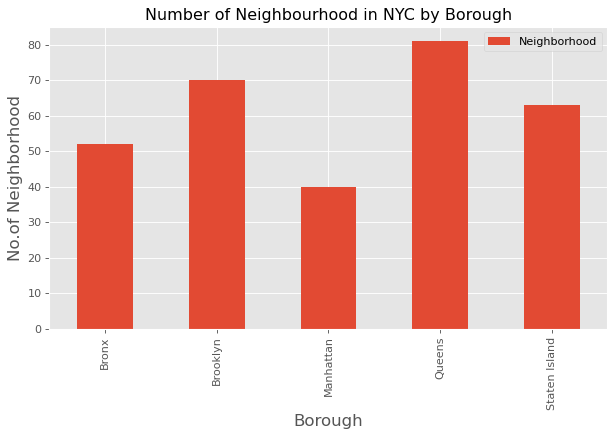

In [45]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
plt.title('Number of Neighbourhood in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

In [46]:
# Queens is the district where there are more neighborhoods, but we started to analyze the Spanish restaurants in New York. In which neighbourhood would it be best to set up a Spanish restaurant? 

In [51]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
spanish_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    spanish_resturants=venues[venues['Category']=='Spanish Restaurant']   
    print('(',count,'/',len(new_york_data),')','Spanish Resturants in '+Neighborhood+', '+Borough+':'+str(len(spanish_resturants)))
    for resturant_detail in spanish_resturants.values.tolist():
        id, name , category=resturant_detail
        spanish_rest_ny = spanish_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Spanish Resturants in Wakefield, Bronx:1
( 2 / 306 ) Spanish Resturants in Co-op City, Bronx:1
( 3 / 306 ) Spanish Resturants in Eastchester, Bronx:0
( 4 / 306 ) Spanish Resturants in Fieldston, Bronx:0
( 5 / 306 ) Spanish Resturants in Riverdale, Bronx:0
( 6 / 306 ) Spanish Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Spanish Resturants in Marble Hill, Manhattan:4
( 8 / 306 ) Spanish Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Spanish Resturants in Norwood, Bronx:2
( 10 / 306 ) Spanish Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Spanish Resturants in Baychester, Bronx:2
( 12 / 306 ) Spanish Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Spanish Resturants in City Island, Bronx:1
( 14 / 306 ) Spanish Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Spanish Resturants in University Heights, Bronx:3
( 16 / 306 ) Spanish Resturants in Morris Heights, Bronx:2
( 17 / 306 ) Spanish Resturants in Fordham, Bronx:5
( 18 / 306 ) Spanish Resturants in East Tremont, Bronx:

KeyError: 'groups'

In [49]:
spanish_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4bec3ac661aca5935cfe8500,El Mangu Tipico Restaurant
1,Bronx,Co-op City,58a9ca678ae363643f8827a2,Sangria Cafe
2,Bronx,Kingsbridge,4ca785a597c8a1cd7e577ba5,El Economico Restaurant
3,Bronx,Kingsbridge,50ea5611e4b044bdeead3ade,Q'Kachapa
4,Manhattan,Marble Hill,4ca785a597c8a1cd7e577ba5,El Economico Restaurant


In [91]:
spanish_rest_ny.shape

(115, 4)

In [ ]:
#115 spanish restaurants in all NeW yORK

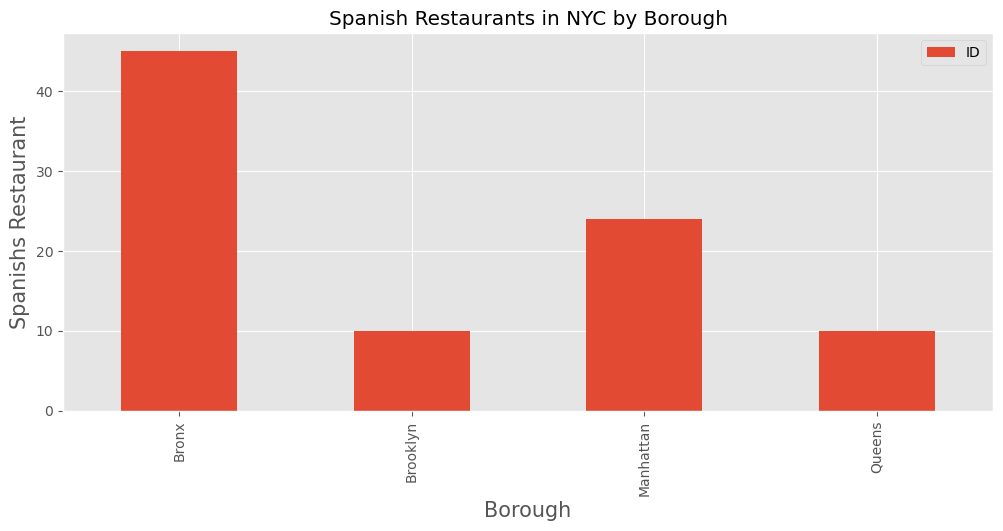

In [50]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(12,5), dpi = 100)
plt.title('Spanish Restaurants in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Spanishs Restaurant', fontsize=15)
spanish_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

In [52]:
bronx_data = new_york_data[new_york_data['Borough'] == 'Bronx'].reset_index(drop=True)
bronx_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Número de restaurantes en Bronx

In [25]:
bronx_data.shape

(52, 4)

In [ ]:
# 52 restaurants in Bronx. ¿How many Spanish restaurants are there per borough?

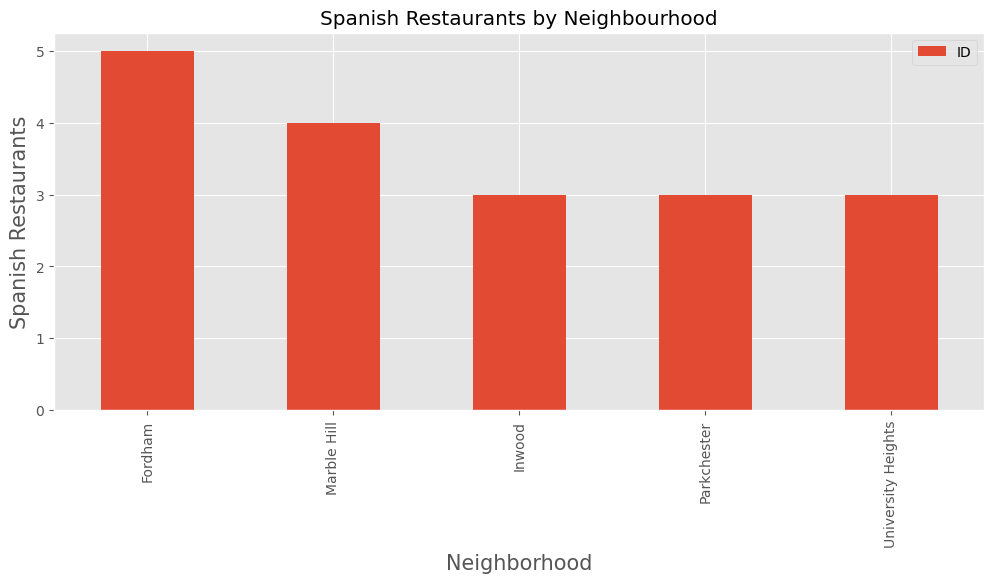

In [53]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,5), dpi = 100)
plt.title('Spanish Restaurants by Neighbourhood')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Spanish Restaurants', fontsize=15)
spanish_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In [ ]:
#Analysis of the ethnic groups in the neighbourhoods

In [59]:
bronx_obj = requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text
soup = BeautifulSoup(bronx_obj,'lxml')
Census_Table = soup.select_one('.wikitable:nth-of-type(5)') 

jurisdictions = []
rows = Census_Table.select("tbody > tr")[3:8]
for row in rows:
    jurisdiction = {}
    tds = row.select('td')
    jurisdiction["jurisdiction"] = tds[0].text.strip()
    jurisdiction["population_census"] = tds[1].text.strip()
    jurisdiction["%_white"] = float(tds[2].text.strip().replace(",",""))
    jurisdiction["%_black_or_african_amercian"] = float(tds[3].text.strip().replace(",",""))
    jurisdiction["%_Asian"] = float(tds[4].text.strip().replace(",",""))
    jurisdiction["%_other"] = float(tds[5].text.strip().replace(",",""))
    jurisdiction["%_mixed_race"] = float(tds[6].text.strip().replace(",",""))
    jurisdiction["%_hispanic_latino_of_other_race"] = float(tds[7].text.strip().replace(",",""))
    jurisdiction["%_catholic"] = float(tds[10].text.strip().replace(",",""))
    jurisdiction["%_jewish"] = float(tds[12].text.strip().replace(",",""))
    jurisdictions.append(jurisdiction)

print(jurisdictions)

[{'jurisdiction': 'Queens', 'population_census': '2,229,379', '%_white': 44.1, '%_black_or_african_amercian': 20.0, '%_Asian': 17.6, '%_other': 12.3, '%_mixed_race': 6.1, '%_hispanic_latino_of_other_race': 25.0, '%_catholic': 37.0, '%_jewish': 5.0}, {'jurisdiction': 'Manhattan', 'population_census': '1,537,195', '%_white': 54.4, '%_black_or_african_amercian': 17.4, '%_Asian': 9.4, '%_other': 14.7, '%_mixed_race': 4.1, '%_hispanic_latino_of_other_race': 27.2, '%_catholic': 11.0, '%_jewish': 9.0}, {'jurisdiction': 'Bronx', 'population_census': '1,332,650', '%_white': 29.9, '%_black_or_african_amercian': 35.6, '%_Asian': 3.0, '%_other': 25.7, '%_mixed_race': 5.8, '%_hispanic_latino_of_other_race': 48.4, '%_catholic': 14.0, '%_jewish': 5.0}, {'jurisdiction': 'Staten Island', 'population_census': '443,728', '%_white': 77.6, '%_black_or_african_amercian': 9.7, '%_Asian': 5.7, '%_other': 4.3, '%_mixed_race': 2.7, '%_hispanic_latino_of_other_race': 12.1, '%_catholic': 11.0, '%_jewish': 5.0}, {

In [60]:
df = pd.DataFrame(jurisdictions, columns=["jurisdiction","%_white", "%_black_or_african_amercian", "%_Asian", "%_other", "%_mixed_race", "%_hispanic_latino_of_other_race"])
df.head()

,jurisdiction,%_white,%_black_or_african_amercian,%_Asian,%_other,%_mixed_race,%_hispanic_latino_of_other_race
0,Queens,44.1,20.0,17.6,12.3,6.1,25.0
1,Manhattan,54.4,17.4,9.4,14.7,4.1,27.2
2,Bronx,29.9,35.6,3.0,25.7,5.8,48.4
3,Staten Island,77.6,9.7,5.7,4.3,2.7,12.1
4,NYC Total,44.7,26.6,9.8,14.0,4.9,27.0


In [ ]:
#The Bronx has the highest rate of Hispanics and Fordham has the highest rate of Spanish restaurants

In [54]:
spanish_rest_ny[spanish_rest_ny['Neighborhood']=='Fordham']

,Borough,Neighborhood,ID,Name
20,Bronx,Fordham,4cf9d4d12d80a14383df40d8,Kasike Mofongo House
21,Bronx,Fordham,4bb7b71998c7ef3bf03e3002,Three Spanish Restaurant
22,Bronx,Fordham,4c6c82f56af58cfac5248717,Elsa La Reina Del Chicharrón (Elsa The Queen O...
23,Bronx,Fordham,4e4d0392bd413c4cc66dfde5,Shalon Restaurant
24,Bronx,Fordham,4c9fcdfc8afca09381840d16,Liberato


In [63]:
# Fordham is the neighbourhood with the most Spanish restaurants. But let's see a classification of them by rating
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
spanish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in spanish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row


column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
spanish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in spanish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(spanish_rest_ny),')','processed')
    spanish_rest_stats_ny = spanish_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 4bec3ac661aca5935cfe8500
( 1 / 79 ) processed
No data available for id= 58a9ca678ae363643f8827a2
( 2 / 79 ) processed
No data available for id= 4ca785a597c8a1cd7e577ba5
( 3 / 79 ) processed
No data available for id= 50ea5611e4b044bdeead3ade
( 4 / 79 ) processed
No data available for id= 4ca785a597c8a1cd7e577ba5
( 5 / 79 ) processed
No data available for id= 50ea5611e4b044bdeead3ade
( 6 / 79 ) processed
No data available for id= 4e3448cd6284ea7e10f38a0f
( 7 / 79 ) processed
No data available for id= 503563a1e4b0aae9b2dbc830
( 8 / 79 ) processed
No data available for id= 4cdadbde958f236a337da903
( 9 / 79 ) processed
No data available for id= 4b7435aef964a52042cd2de3
( 10 / 79 ) processed
No data available for id= 4be2ecf6b02ec9b6a5064ec0
( 11 / 79 ) processed
No data available for id= 58a9ca678ae363643f8827a2
( 12 / 79 ) processed
No data available for id= 531f7ea1498e56210466e0bd
( 13 / 79 ) processed
No data available for id= 4e4d0392bd413c4cc66dfde5
( 14 / 79

In [58]:
#When we get all the data from the restaurants we save them in a csv as we have the limit per day at 500. 

spanish_rest_stats_ny.to_csv('spanish_rest_stats_ny.csv', index=False)

In [8]:
spanish_rest_stats_ny_csv=pd.read_csv('spanish_rest_stats_ny.csv')

In [9]:
spanish_rest_stats_ny_csv.shape

(115, 7)

In [29]:
spanish_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0.0,0.0,0
1,Bronx,Co-op City,58a9ca678ae363643f8827a2,Sangria Cafe,7.0,7.2,3
2,Bronx,Kingsbridge,4ca785a597c8a1cd7e577ba5,El Economico Restaurant,18.0,7.6,8
3,Bronx,Kingsbridge,50ea5611e4b044bdeead3ade,Q'Kachapa,16.0,7.3,6
4,Manhattan,Marble Hill,4ca785a597c8a1cd7e577ba5,El Economico Restaurant,18.0,7.6,8


In [12]:
spanish_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       115 non-null    object 
 1   Neighborhood  115 non-null    object 
 2   ID            115 non-null    object 
 3   Name          115 non-null    object 
 4   Likes         115 non-null    int64  
 5   Rating        115 non-null    float64
 6   Tips          115 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.4+ KB


In [13]:
spanish_rest_stats_ny_csv['Likes']=spanish_rest_stats_ny_csv['Likes'].astype('float64')

In [14]:
spanish_rest_stats_ny_csv['Rating']=spanish_rest_stats_ny_csv['Rating'].astype('float64')

In [16]:
#Likes
spanish_rest_stats_ny_csv.iloc[spanish_rest_stats_ny_csv['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                  Baychester
ID              4be2ecf6b02ec9b6a5064ec0
Name                     Caridad & Louie
Likes                                 66
Rating                                 8
Tips                                  27
Name: 10, dtype: object

In [17]:
spanish_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       115 non-null    object 
 1   Neighborhood  115 non-null    object 
 2   ID            115 non-null    object 
 3   Name          115 non-null    object 
 4   Likes         115 non-null    float64
 5   Rating        115 non-null    float64
 6   Tips          115 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 6.4+ KB


In [18]:
spanish_rest_stats_ny_csv.iloc[spanish_rest_stats_ny_csv['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4c8be9fa509e3704e0822e55
Name                      Brisas Express
Likes                                  9
Rating                               8.4
Tips                                   6
Name: 32, dtype: object

In [19]:
spanish_rest_stats_ny_csv.iloc[spanish_rest_stats_ny_csv['Rating'].idxmin()]

Borough             Bronx
Neighborhood    Wakefield
ID                      0
Name                    0
Likes                   0
Rating                  0
Tips                    0
Name: 0, dtype: object

In [20]:
ny_neighborhood_stats=spanish_rest_stats_ny_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [57]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
60,Parkchester,7.766667
52,Mott Haven,7.600000
1,Baychester,7.600000
39,Kingsbridge,7.450000
14,Co-op City,7.200000
28,Fordham,7.080000
4,Belmont,7.050000
49,Morris Heights,6.900000
71,University Heights,6.800000
36,Hunts Point,6.600000


In [21]:
ny_borough_stats=spanish_rest_stats_ny_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [22]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
0,Bronx,4.819231
1,Brooklyn,0.740000
2,Manhattan,0.596000
3,Queens,0.000000
4,Staten Island,0.000000


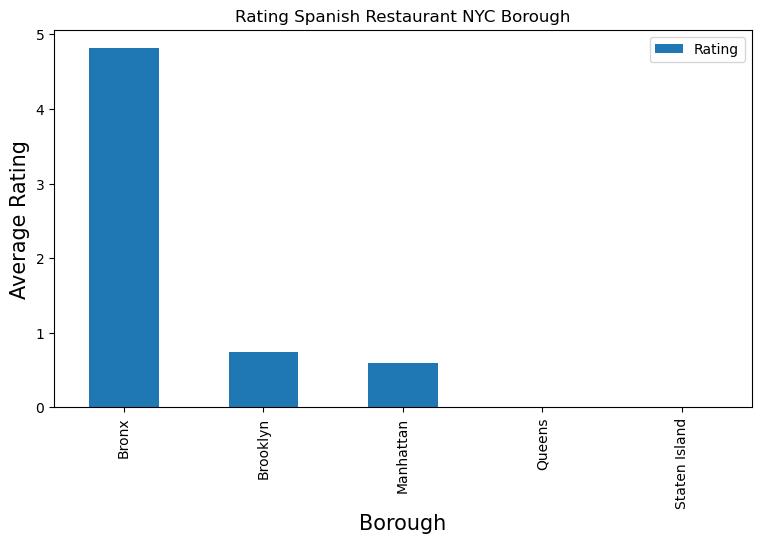

In [24]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Rating Spanish Restaurant NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
spanish_rest_stats_ny_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
#The Bronx has the highest number of restaurants, with an average of the best opinion of them, and the Fordham neighborhood has the highest number of Spanish restaurants